In [30]:
import netCDF4 as nc
import numpy as np
import pylab as plt
import xarray as xr
import glob

maindir = '/projects/awaken/j3lee/run_amrw/stable/s3_20180612-10m-p/'
stat_dir = 'post_processing'

forcing_nc = 'forcing_20180612_raj.nc'

lidar_dir = '/projects/awaken/j3lee/arm-data/sgpdlprofwstats4newsC1/'
lidar_file = 'sgpdlprofwstats4newsC1.c1.20180612.000000.custom.nc'

sim_name = '2018-06-12_10-m_ppm-nolim'

# in UTC
start_time = 3
# in hours
sim_duration = 6

In [31]:
# when using xarray multifile dataset, have to grab each group of the nc files individually
xtime = xr.open_mfdataset(maindir+stat_dir+'/abl_statistics*.nc', 
                          concat_dim=['num_time_steps'], combine='nested')

sim_prof = xr.open_mfdataset(maindir+stat_dir+'/abl_statistics*.nc', group='mean_profiles', 
                             concat_dim=['num_time_steps'], combine='nested')

# remove duplicated times
_, index = np.unique(xtime['time'], return_index=True)
xtime = xtime.isel(num_time_steps=index)
sim_prof = sim_prof.isel(num_time_steps=index)

nc_file_num = len(glob.glob1(maindir+stat_dir, 'abl_statistics*.nc'))

if nc_file_num == 1: 
    sim_height = sim_prof['h'].values
else: 
    sim_height = sim_prof['h'].values[0,:] 
# print(sim_height.shape)
# print(sim_height)
sim_time = np.round(xtime['time'].values)
# print(sim_time.shape)
# print(sim_time)

# the forcing file used for the simulation 
forcing = nc.Dataset(maindir+forcing_nc)
# print(forcing.variables.keys())

forcing_height = forcing['heights'][:]
forcing_time = forcing['times'][:]
n_fh = len(forcing_height)
n_ft = len(forcing_time)
# or n_fh = forcing.dimensions['nheight'].size

forcing_momu = np.reshape(forcing['wrf_momentum_u'][:], (n_ft, n_fh))
forcing_momv = np.reshape(forcing['wrf_momentum_v'][:], (n_ft, n_fh))
forcing_temp = np.reshape(forcing['wrf_temperature'][:], (n_ft, n_fh))

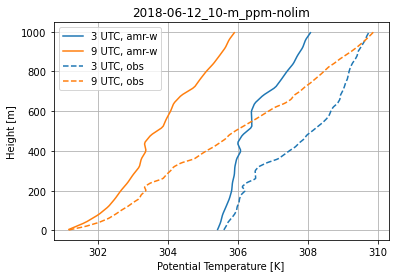

In [32]:
plt.plot(sim_prof['theta'].values[0,:], sim_height, 
         label=str(start_time)+' UTC, amr-w')
plt.plot(sim_prof['theta'].values[-1,:], sim_height, 
         label=str(start_time+sim_duration)+' UTC, amr-w')

plt.plot(forcing_temp[0,:], forcing_height, linestyle='dashed', color='C0', 
         label=str(start_time)+' UTC, obs')
plt.plot(forcing_temp[-1,:], forcing_height, linestyle='dashed', color='C1', 
         label=str(start_time+sim_duration)+' UTC, obs')
plt.xlabel('Potential Temperature [K]')
plt.ylabel('Height [m]')
plt.title(sim_name)
plt.legend()
plt.grid(True)

plt.show()

In [33]:
def plot_sim_forcing_contour(sim_prof_var, forcing_var, legend_txt, title_txt):
    
    fig, ax = plt.subplots(figsize=(10, 6), ncols=2, sharey=True, sharex=True)

    contour_min = np.min([sim_prof[sim_prof_var].values.min(), forcing_var.min()])
    contour_max = np.max([sim_prof[sim_prof_var].values.max(), forcing_var.max()])

    im = ax[0].contourf(sim_time, sim_height, sim_prof[sim_prof_var].values.T, 
                        levels=np.linspace(contour_min, contour_max))
    ax[1].contourf(forcing_time, forcing_height, forcing_var.T, 
                   levels=np.linspace(contour_min, contour_max))

    plt.xlim(0, sim_time.max())
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax, label=legend_txt)
    plt.suptitle(title_txt+' '+sim_name)

    ax[0].set_xlabel('Seconds since '+str(start_time)+' UTC')
    ax[1].set_xlabel('Seconds since '+str(start_time)+' UTC')
    ax[0].set_ylabel('Height AGL [m]')

    ax[0].set_title('Simulation')
    ax[1].set_title('Forcing')

    plt.show()

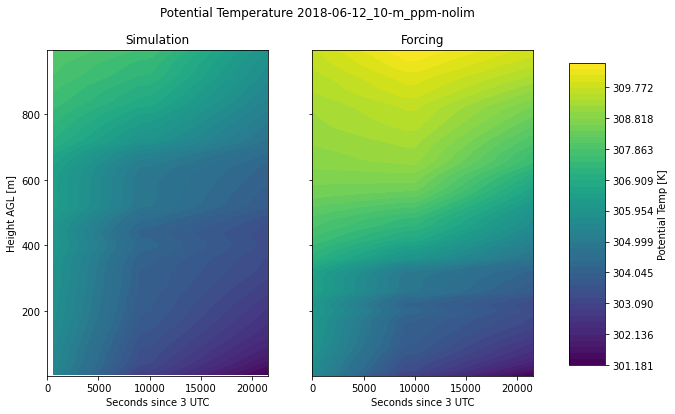

In [34]:
plot_sim_forcing_contour('theta', forcing_temp, 'Potential Temp [K]', 'Potential Temperature')

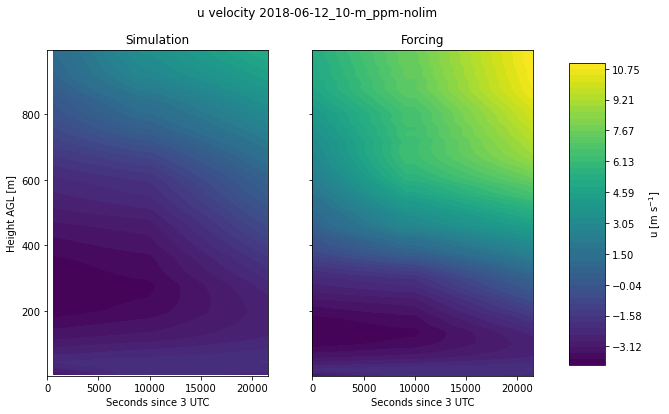

In [35]:
plot_sim_forcing_contour('u', forcing_momu, r'u [m s$^{-1}$]', 'u velocity')

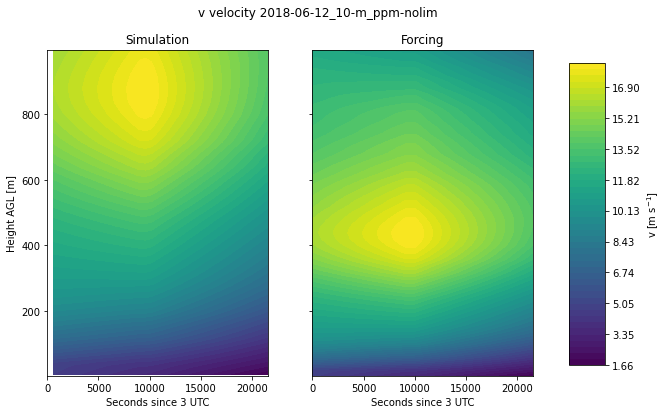

In [36]:
plot_sim_forcing_contour('v', forcing_momv, r'v [m s$^{-1}$]', 'v velocity')

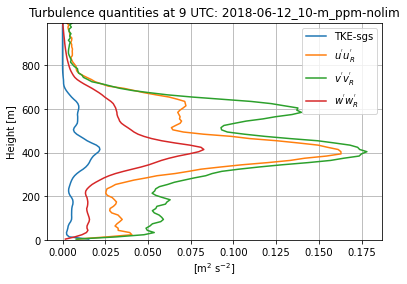

In [37]:
plt.plot(sim_prof['k_sgs'].values[-1,:], sim_height, 
         color='C0', label='TKE-sgs')
plt.plot(sim_prof['u\'u\'_r'][-1,:], sim_height, 
         color='C1', label=r"$u^{'}u^{'}_{R}$")
plt.plot(sim_prof['v\'v\'_r'][-1,:], sim_height, 
         color='C2',label=r"$v^{'}v^{'}_{R}$")
plt.plot(sim_prof['w\'w\'_r'][-1,:],sim_height, 
         color='C3',label=r"$w^{'}w^{'}_{R}$")
plt.ylim(0, sim_height.max())
# plt.xlim(-0.001,0.45)
plt.grid(True)
plt.title('Turbulence quantities at '+str(start_time+sim_duration)+' UTC: '+sim_name)
plt.ylabel('Height [m]')
plt.xlabel('[m$^2$ s$^{-2}$]')
plt.legend()
plt.show()

In [41]:
#wstat = nc.Dataset('/projects/awaken/ckaul/wrfForcing/20170628/225451/sgpdlprofwstats4newsC1.c1.20170629.000000.nc')
wstat = nc.Dataset(lidar_dir+lidar_file)
# print(wstat.variables.keys())
wvar = wstat.variables['w_variance'][:,:]
snr = wstat.variables['snr'][:,:]
noise = wstat.variables['noise'][:,:]

wvar = np.ma.masked_where(snr < 0.008, wvar)
# wvar = np.ma.masked_where(noise > 1, wvar) --this masks almost everything, need to ask Rob about it

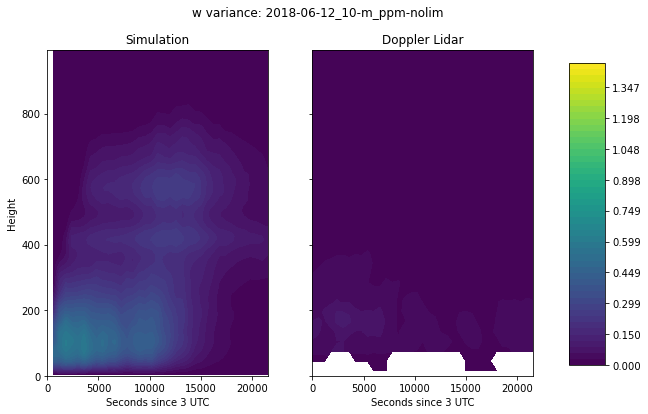

In [39]:
fig, ax = plt.subplots(figsize=(10,6),ncols=2,sharey=True,sharex=True)

contour_min = np.min([sim_prof['w\'w\'_r'].values.min(), wvar.min()])
contour_max = np.max([sim_prof['w\'w\'_r'].values.max(), wvar.max()])

im = ax[0].contourf(sim_time, sim_height, sim_prof['w\'w\'_r'][:,:].T, 
                    levels=np.linspace(contour_min ,contour_max))
ax[1].contourf(wstat.variables['time'][:]-start_time*3600, wstat.variables['height'][:], 
               wvar[:,:].T, levels=np.linspace(contour_min, contour_max))

plt.xlim(0, sim_time.max())
plt.ylim(0, sim_height.max())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
ax[0].set_ylabel('Height')
ax[0].set_xlabel('Seconds since '+str(start_time)+' UTC')
ax[1].set_xlabel('Seconds since '+str(start_time)+' UTC')
ax[0].set_title('Simulation')
ax[1].set_title('Doppler Lidar')
plt.suptitle('w variance: '+sim_name)

plt.show()

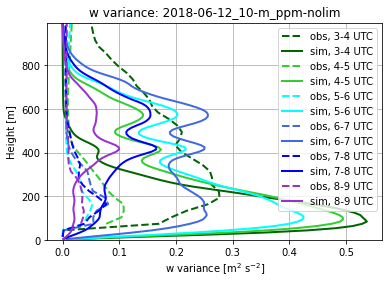

In [40]:
hour_interval_sec = (np.arange(sim_duration+1))*3600

line_c = ['darkgreen', 'limegreen', 'cyan', 'royalblue', 'blue', 'darkorchid']

for ind, val in enumerate(hour_interval_sec[:-1]):
    
    start_hr = str(start_time+ind)
    end_hr = str(start_time+ind+1)

    wstat_t = [i for i,v in enumerate(wstat.variables['time'][:])
               if v > val and v <= hour_interval_sec[ind+1]]
    
    plt.plot(np.ma.mean(wvar[min(wstat_t):max(wstat_t),:],axis=0), 
             wstat.variables['height'][:], c=line_c[ind],
             label='obs, '+start_hr+'-'+end_hr+' UTC', linewidth=2, linestyle='--')
    
    sim_t = [i for i,v in enumerate(sim_time)
             if v > val and v <= hour_interval_sec[ind+1]]
    
    plt.plot(np.mean(sim_prof['w\'w\'_r'][min(sim_t):max(sim_t),:],axis=0), 
             sim_height, c=line_c[ind], 
             label='sim, '+start_hr+'-'+end_hr+' UTC', linewidth=2)
    
plt.ylim(0, sim_height.max())
# plt.xlim(-0.001,4)
# plt.yticks(np.arange(200,2600,200))
plt.grid(True)
plt.legend()
plt.ylabel(r'Height [m]')
plt.xlabel(r'w variance [m$^2$ s$^{-2}$]')
plt.title('w variance: '+sim_name)
plt.show()